## Task
1. see how many such game sentences with AtLocation we can create, and how many answers they have on average (the example above has 3 answers).  Also, inspect their quality and if you detect problems, see how they can be addressed.
2. Think and investigate how other relations can be used to create related tasks. I think some should be possible, like UsedFor in this example: "I want to cut paper so I will need knife or scissors". You don't need to think about all relations but take some subset of let's say 10 that seem promising.
3. Take the 50 household items from EQA that we worked with, and generate random walks of length 2 and 3 on the graph starting with them. Example for a random walk of length 2 is: toaster-LocatedAt-kitchen-UsedFor-cooking. You could do this with graph-tools for example (https://graph-tool.skewed.de/static/doc/quickstart.html)
4. Think and investigate how can we generate game sentences with these walks, and whether it makes sense. One option would be to do something like "A toaster can be located in a place that is used for cooking and baking."  Even if we can do this for a small set of patterns, it would be useful. The solution could also use disambiguation or other NLP tricks. 
5. It would be useful to see some examples where we can use these walks to create sentences. You don't need to code this last part 5.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import random, re
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

## Set up Folder

In [2]:
# input
cskg_dim_folder="./data/cskg_dim/cskg_dim.tsv"

# output
AtLocation_sents_file="./data/psl/AtLocation_sents.txt"
gamesents_file="./data/psl/gamesents.txt"

## Function

In [3]:
def load_source(filename):
    with open(filename,"r",encoding="utf-8") as f:
        head=f.readline().strip().split("\t")
        data=[]
        for line in f:
            temp=line.strip().split("\t")
            data.append([item.split("|")[0] for item in temp])
            
    return head, data

def data_filter(head, lines, filter_={"relation":["/r/AtLocation"]}):
    # filter the lines woth limitation
    for head_name in filter_:
        filter_values=filter_[head_name]
        line_index=head.index(head_name)
        
        for filter_value in filter_values:
            filter_lines=[]
            for line in lines:
                if line[line_index]==filter_value:
                    filter_lines.append(line)
            yield filter_value,filter_lines
        
def build_sentence(lines, sent_format='f"I am going to {blank1} and I am going to see {blank2}"',operation="or",reverse_format=False):
    # build dictionary structure
    top_bot=dict()
    if not reverse_format:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(object_label,[])
            temp.append(subject_label)

            top_bot[object_label]=temp
            
    else:
        for line in lines:
            subject_id=line[1]
            subject_label=line[4]

            object_id=line[3]
            object_label=line[5]

            temp=top_bot.get(subject_label,[])
            temp.append(object_label)

            top_bot[subject_label]=temp
    
    # build sentence
    sents=[]
    for top in top_bot:
        bots=top_bot[top]
        
        blank1=top
        blank2=f" {operation} ".join(bots)
        sents.append(eval(sent_format).replace("_"," "))
        
    return sents, top_bot

In [4]:
cskg_dim_head,cskg_dim_lines=load_source(cskg_dim_folder)

In [5]:
# head
cskg_dim_head

['id',
 'node1',
 'relation',
 'node2',
 'node1;label',
 'node2;label',
 'relation;label',
 'relation;dimension',
 'source',
 'sentence']

In [6]:
# example of lines
cskg_dim_lines[0]

['/c/en/0-/r/DefinedAs-/c/en/empty_set-0000',
 '/c/en/0',
 '/r/DefinedAs',
 '/c/en/empty_set',
 '0',
 'empty set',
 'defined as',
 'similarity',
 'CN',
 '[[0]] is the [[empty set]].']

## AtLocation Sentence

In [7]:
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":["/r/AtLocation"]}))

In [8]:
mul_filter_lines[0][1][0]

['/c/en/00t_shirts-/r/AtLocation-/c/en/drawer-0000',
 '/c/en/00t_shirts',
 '/r/AtLocation',
 '/c/en/drawer',
 '00t shirts',
 'drawer',
 'at location',
 'spatial',
 'CN',
 '*Something you find in [[a drawer]] is [[00t-shirts]]']

In [9]:
AtLocation_sents,AtLocation_dict = build_sentence(mul_filter_lines[0][1])
print("game sentences with AtLocation we can create:",len(AtLocation_dict))

# statistic of location sentence
example_distribution=[len(AtLocation_dict[item]) for item in AtLocation_dict]
avg_example= sum(example_distribution)/len(AtLocation_dict)
print("answers they have on average:", avg_example)

game sentences with AtLocation we can create: 7771
answers they have on average: 3.5770171149144256


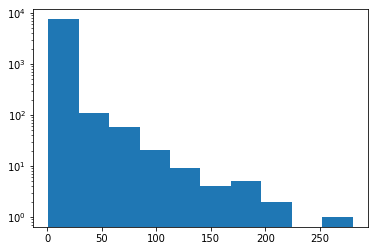

In [10]:
a=plt.hist(example_distribution,log=True)

In [11]:
# save file into desk
with open(AtLocation_sents_file,"w",encoding="utf-8") as f:
    for line in AtLocation_sents:
        f.write(line+"\n")

## More Sentences

In [12]:
# check the distribution of relation id
rel_dict=dict()
for line in cskg_dim_lines:
    rel_dict[line[2]]=rel_dict.get(line[2],0)+1
    
print("number of relation id:", len(rel_dict))

number of relation id: 47


In [13]:
rel_dict

{'/r/DefinedAs': 2173,
 '/r/HasContext': 238277,
 '/r/HasProperty': 9482,
 '/r/IsA': 316351,
 '/r/RelatedTo': 1703968,
 '/r/SimilarTo': 30635,
 '/r/Antonym': 401003,
 '/r/Synonym': 1245289,
 '/r/FormOf': 378859,
 '/r/AtLocation': 27797,
 '/r/DerivedFrom': 325914,
 '/r/EtymologicallyRelatedTo': 32075,
 '/r/CapableOf': 42375,
 '/r/InstanceOf': 1480,
 '/r/PartOf': 31964,
 '/r/MadeOf': 2757,
 '/r/ReceivesAction': 6037,
 '/r/HasA': 16973,
 '/r/UsedFor': 42580,
 '/r/NotHasProperty': 327,
 '/r/CausesDesire': 4688,
 '/r/HasSubevent': 25369,
 '/r/LocatedNear': 152274,
 '/r/DistinctFrom': 8249,
 '/r/MannerOf': 12618,
 '/r/Entails': 405,
 '/r/HasPrerequisite': 24977,
 '/r/NotCapableOf': 329,
 '/r/MotivatedByGoal': 9489,
 '/r/Desires': 3170,
 '/r/Causes': 17388,
 '/r/HasFirstSubevent': 3347,
 '/r/HasLastSubevent': 2874,
 '/r/NotDesires': 2886,
 '/r/CreatedBy': 450,
 '/r/EtymologicallyDerivedFrom': 71,
 '/r/SymbolOf': 4,
 'at:xAttr': 133281,
 'at:xEffect': 100307,
 'at:xIntent': 57685,
 'at:xReact'

In [14]:
#define the first word and second word used for build sentence:
# example:
# [I am going to], [and I am going to see]
relation_sentence={"/r/UsedFor":[['f"I want to {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to have {blank1} so I will need {blank2}"',"or",False],
                                 ['f"I want to be {blank1} so I will need {blank2}"',"or",False]],
                   "/r/CreatedBy":[['f"I have {blank1} so I can create {blank2}"',"or", False]],
                   "/r/CapableOf":[['f"I have {blank1} so I am capable of {blank2}"',"or", True],
                                     ['f"I am {blank1} so I am capable of {blank2}"',"or", True]],
                   "/r/Causes":[['f"I have {blank1} so I will cause {blank2}"',"or", True],
                                  ['f"I am {blank1} so I will cause {blank2}"',"or", True]],
                   "/r/PartOf":[['f"I have {blank1} so I might also have {blank2}"',"or", False],
                                  ['f"I am {blank1} so I might also have {blank2}"',"or", False]],
                   "/r/MadeOf":[['f"I want to have {blank1} so I can make it from {blank2}"',"or", True]],
                   "/r/HasPrerequisite":[['f"If I want to {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to be {blank1} then I should {blank2}"',"or", True],
                                           ['f"If I want to have {blank1} then I should {blank2}"',"or", True]],
                   "/r/CausesDesire":[['f"I want to {blank1} then I want to {blank2}"',"or", False],
                                        ['f"I want to {blank1} then I have {blank2}"',"or", False]],
                   "/r/NotDesires":[['f"I am {blank1} and I don\'t want to {blank2}"',"or", True]],
                   "/r/AtLocation":[['f"I need {blank1} so I will go to see {blank2}"',"or", True]],
                   '/r/LocatedNear':[['f"I am going to {blank1} and I am going to see {blank2} nearby"',"or", True]]}


# get the sentence that having the relation in relation_sentence
mul_filter_lines=list(data_filter(cskg_dim_head, cskg_dim_lines, filter_={"relation":relation_sentence.keys()}))

In [15]:
sents_example=[]
with open(gamesents_file,"w",encoding="utf-8") as f:
    for rel_id, lines in mul_filter_lines:
        temp= []
        for format_ in relation_sentence[rel_id]:
            sents,example_dict = build_sentence(lines,
                                 sent_format=format_[0],
                                 operation=format_[1],
                                 reverse_format=format_[2],)
            #print("relation id:",rel_id)
            #print("game sentences we can create:",len(sents))
            example_distribution=[len(example_dict[item]) for item in example_dict]
            avg_example= sum(example_distribution)/len(example_dict)
            #print("answers they have on average:", avg_example)
            #print("example of sentences:",sents[250])
            #print()
            if not temp:
                temp= [[sents[i]] for i in range(len(sents))]
            else:
                temp=[temp[i]+[sents[i]] for i in range(len(sents))]

        sents_example.append([rel_id,temp,example_dict])

        # save file into desk

        #f.write("**"+rel_id+"**\n")
        #for line in sents:
        #   f.write(line+"\n")

## Score sentence

In [16]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def score(tokens_tensor):
    loss=model(tokens_tensor, labels=tokens_tensor)[0]
    return np.exp(loss.cpu().detach().numpy())

def sents_pick(sents,scores,perplexity_threhold=100):
    i = min(len(sents), len(scores))
    sents_result=[]
    for idx in range(i):
        sent_collect=sents[idx]
        score_collect=scores[idx]
        
        temp=float("inf")
        result=""
        
        result_idx=0
        temp_idx=0
        for sent, score in zip(sent_collect,score_collect):
            if temp>score:
                temp=score
                result=sent
                result_idx=temp_idx
            temp_idx+=1
        if temp < perplexity_threhold:
            sents_result.append([result_idx,result])
        
    return sents_result

In [17]:
relation_scores=[]
for relation_collection in sents_example:
    rel_id=relation_collection[0]
    scores=[]
    print("process relation id:", rel_id)
    for sents in tqdm(relation_collection[1]):
        temp=[]
        for sent in sents:
            # too long sentence might out of index
            if len(sent)>2000:
                temp.append(float("inf"))
                continue
            tokens_tensor = tokenizer.encode(sent, add_special_tokens=False, return_tensors="pt")           
            temp.append(score(tokens_tensor))
        scores.append(temp)
    relation_scores.append([rel_id,scores])

  0%|          | 1/30174 [00:00<1:28:01,  5.71it/s]

process relation id: /r/UsedFor


  1%|          | 4/388 [00:00<00:11, 32.66it/s]

process relation id: /r/CreatedBy


  0%|          | 2/11488 [00:00<12:38, 15.15it/s]

process relation id: /r/CapableOf


  0%|          | 0/1980 [00:00<?, ?it/s]

process relation id: /r/Causes


  0%|          | 0/14005 [00:00<?, ?it/s]

process relation id: /r/PartOf


  0%|          | 3/2239 [00:00<01:17, 28.86it/s]

process relation id: /r/MadeOf


  0%|          | 1/3942 [00:00<07:27,  8.81it/s]

process relation id: /r/HasPrerequisite


  0%|          | 2/598 [00:00<00:58, 10.22it/s]

process relation id: /r/CausesDesire


  1%|          | 3/255 [00:00<00:10, 23.94it/s]

process relation id: /r/NotDesires


  0%|          | 3/9894 [00:00<05:50, 28.18it/s]

process relation id: /r/AtLocation


  0%|          | 3/16154 [00:00<09:27, 28.46it/s]

process relation id: /r/LocatedNear


100%|██████████| 16154/16154 [11:04<00:00, 24.33it/s]


In [18]:
# find the sentence with highest score/lowest perplexity and satisfy threshold
filtered_sents_example=[]

for idx_1 in range(len(sents_example)):
    rel_id=sents_example[idx_1][0]
    example_dict=sents_example[idx_1][2]
    sents=sents_example[idx_1][1]
    scores=relation_scores[idx_1][1]
    
    filtered_sent=sents_pick(sents,scores)
    filtered_sents_example.append([rel_id,filtered_sent,example_dict])

In [19]:
# based on the string pattern build edges
edges=[]
for relation_sents in filtered_sents_example:
    rel_id=relation_sents[0]
    ids_sents=relation_sents[1]
    patterns_=relation_sentence[rel_id]
    for id_, sent in tqdm(ids_sents):
        pattern_undefine=patterns_[id_][0]
        reverse=patterns_[id_][2]
        connection=patterns_[id_][1]
        pattern=pattern_undefine.replace("{blank1}","(.*)").replace("{blank2}","(.*)").replace('f"',"").replace('"',"")
        
        blank1,blank2s=re.findall(pattern, sent)[0]
        blank2s_list=blank2s.split(" "+connection+" ")
        
        for blank2 in blank2s_list:
            if reverse:
                subject_=blank1
                object_=blank2
                edges.append([subject_,rel_id,object_])
            else:
                subject_=blank2
                object_=blank1
                edges.append([subject_,rel_id,object_])

100%|██████████| 1633/1633 [00:00<00:00, 46605.28it/s]


3.6594694632942626
1.375
14.898009950248756
29.209183673469386
5.151807228915662
1.24
12.447835344215756
8.895348837209303
1.2828282828282829
13.139393939393939
38.519902020820574


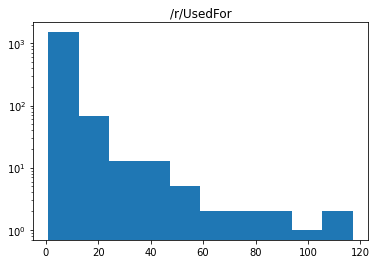

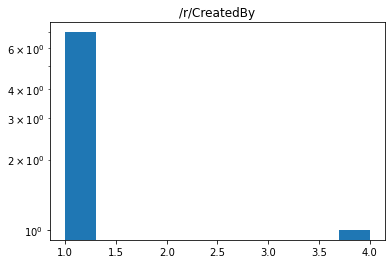

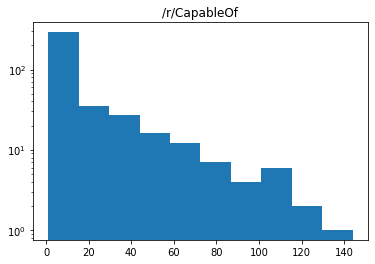

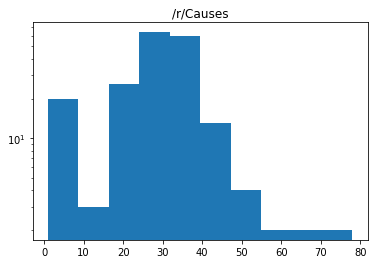

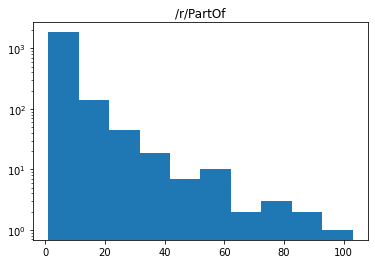

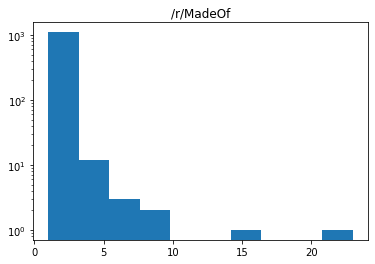

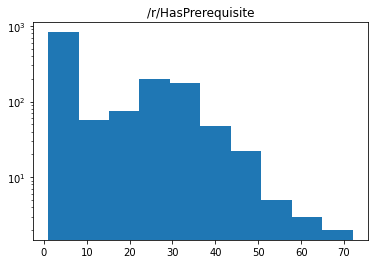

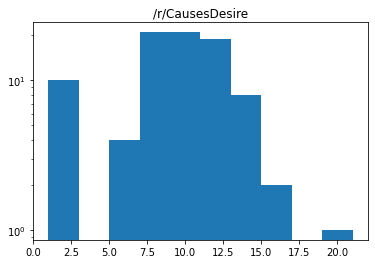

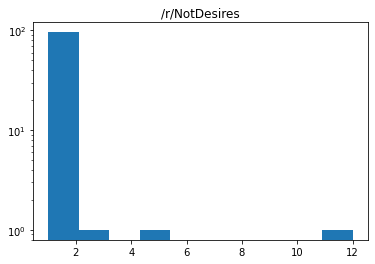

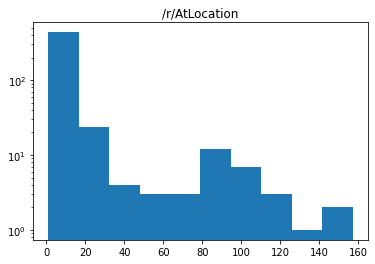

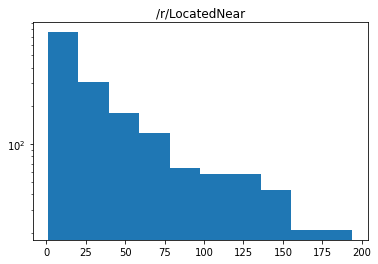

In [20]:
# calculate the number of answer for different relation id

for relation_sents in filtered_sents_example:
    fig = plt.figure()
    # count the number of " or " n1 in the sentence
    # the answer of one sentence is n1+1
    rel_id=relation_sents[0]
    id_sents=relation_sents[1]
    distribution=[]
    for id_, sent in id_sents:
        num_or = sent.count(" or ")
        distribution.append(num_or+1)    
    a=plt.hist(distribution,log=True)
    plt.title(rel_id)
    print(sum(distribution)/len(distribution))

# Build Graph

In [21]:
def add2graph(graph, rel_id, subject_, object_,rel_set=relation_sentence):
    temp = graph_tool.util.find_vertex(g, g.vp["position"], subject_)
    if not temp:
        a = graph.add_vertex()
        g.vp["position"][a]=subject_
    else:
        a=temp[0]
        
    temp = graph_tool.util.find_vertex(g, g.vp["position"], object_)
    if not temp:
        b = graph.add_vertex()
        g.vp["position"][b]=object_
    else:
        b=temp[0]
        
    edge_loc=graph_tool.util.find_edge(g, g.ep["position"], rel_id)
    if not edge_loc:
        reverse=relation_sentence[rel_id][2]
        
        if reverse==True:
            c = graph.add_edge(a, b)
            g.ep["position"][c]=rel_id.split("/")[-1].split(":")[-1]
        else:
            c = graph.add_edge(b, a)
            g.ep["position"][c]=rel_id.split("/")[-1].split(":")[-1]
    else:
        c = edge_loc[0]
        
    return

def random_walk(num=2):
    step=0
    process=[]
    root=None
    
    while step<num:
        # random select root
        if root == None:
            root_name = random.sample(label_limit, 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                continue
            
        else:
            #print(list(root.out_neighbors()))
            root_name= random.sample(root.keys(), 1)[0]
            if root_name in G:
                root=G[root_name]
            else:
                step=0
                process=[]
                root=None
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            step=0
            process=[]
            root=None
            continue
        
        #print(root,root.out_degree())
        if root_name in process:
            step=0
            process=[]
            root=None
            continue
        process.append(root_name)
        step+=1
    process.append(random.sample(root.keys(), 1)[0]) 
    return process

def all_relation_walk(threshold=100,relation_list=["/r/UsedFor"]):
    # generate a sentence with all relation labels
    relation_set=set(relation_list)
    process=[]
    root_name=""
    step=0
    
    while step<threshold:
        #print(process, step,relation_set,threshold,root_name)
        step+=1
        if root_name == "":
            root_name = random.sample(label_limit, 1)[0].replace(" ","_")
            if root_name in G:
                pass
            else:
                root_name = ""
                continue
                
        else:
            #print(list(root.out_neighbors()))
            all_edges=list(G.out_edges(root_name, data=True))
            random.shuffle(all_edges)
            status = False
            for sub, obj, rel in all_edges:
                rel_label=rel["label"]
                if rel_label in relation_set:
                    status=True
                    break
            
            if status:
                root_name=obj
                relation_set.remove(rel_label)
                if relation_set==set():
                    process.append(root_name)
                    break
            else:
                process=[]
                root_name=""
                relation_set=set(relation_list)
                continue
            #print("second root", root)
        
        if G.out_degree[root_name]==0:
            process=[]
            root_name=""
            relation_set=set(relation_list)
            continue
        
        #print(root,root.out_degree())
        # remove duplicate
        if root_name in process:
            process=[]
            root_name=""
            continue

        process.append(root_name)
    return process

def walk_sent(process):
    sent=""
    for p2 in range(1, len(process)):
        p1=p2-1
        sub=process[p1].replace(" ","_")
        obj=process[p2].replace(" ","_")
        
        relation_=G[sub][obj]["label"]
        
        if sent:
            sent+="-"+relation_+"-"+obj
        else:
            sent=sub+"-"+relation_+"-"+obj
            
    return sent

def walk2gamesents(sent, relation2label, relation_swap={"/r/LocatedNear"}):
    sent_token=sent.split("-")
    gamesent=""
    i=0
    while i < len(sent_token):
        if i==0:
            gamesent+=sent_token[i].replace("_"," ")
        
        elif i==1:
            rel_id=sent_token[i]
            if rel_id in relation_swap:
                rel_label=G_total[sent_token[i-1]][sent_token[i+1]]["label"]
            else:
                rel_label=relation2label[sent_token[i]]
            
            gamesent+=" "+rel_label
            
        elif (i+1)%2==0:
            gamesent+=" "+ "that"+" "+relation2label[sent_token[i]]
        
        else:
            gamesent+= " "+sent_token[i].replace("_"," ")
        i+=1
    return gamesent

In [22]:
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near in"}

In [23]:
label_limit = set(["rug","piano","dryer","computer","fireplace","whiteboard","bookshelf","wardrobe cabinet",
                  "pan","toilet","plates","ottoman","fish tank","dishwasher","microwave","water dispenser",
                  "bed","table","mirror","tv stand","stereo set","chessboard","playstation","vacuum cleaner",
                  "cup","xbox","heater","bathtub","shoe rack","range oven","refrigerator","coffee machine",
                  "sink","sofa","kettle","dresser","knife rack","towel rack","loudspeaker","utensil holder",
                  "desk","vase","shower","washer","fruit bowl","television","dressing table","cutting board",
                  "ironing board","food processor"])

In [24]:
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    G.add_edge(sub,obj,label=rel)

In [25]:
# build the graph for the whole dataset.
G_total= nx.DiGraph()
for line in cskg_dim_lines:
    G_total.add_edge(line[4].replace(" ","_"),line[5].replace(" ","_"),label=line[6])

In [50]:
#show 10 example
for i in range(10):
    temp=random_walk(num=3)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    value=score(tokens_tensor)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print(value)
    print()

random walk:  piano-/r/LocatedNear-stool-/r/LocatedNear-towel-/r/LocatedNear-puppy
gamesentence is:  piano with stool that is located near in towel that is located near in puppy
387.08466

random walk:  toilet-/r/LocatedNear-toilet_bowl-/r/LocatedNear/r-spot-/r/LocatedNear-line
gamesentence is:  toilet has toilet bowl that is located near in spot that is located near in line
210.85747

random walk:  bathtub-/r/LocatedNear/r-sponge-/r/LocatedNear-hand-/r/LocatedNear/r-leash
gamesentence is:  bathtub is located near in sponge that is located near in hand that is located near in leash
125.037865

random walk:  shower-/r/LocatedNear/r-tray-/r/LocatedNear/r-lotion-/r/UsedFor-moisturizing_skin
gamesentence is:  shower is located near in tray that is located near in lotion that is used for moisturizing skin
127.34306

random walk:  sink-/r/LocatedNear-left_side-/r/LocatedNear/r-cheese-/r/LocatedNear-muffin
gamesentence is:  sink has left side that is located near in cheese that is located nea

In [27]:
#show 10 example
for i in range(10):
    temp=random_walk(num=2)
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    print("random walk: ", sent)
    print("gamesentence is: ", gamesent)
    print()

random walk:  desk-/r/LocatedNear-globe-/r/LocatedNear-light_fixture
gamesentence is:  desk behind globe that is located near in light fixture

random walk:  bathtub-/r/LocatedNear-room-/r/LocatedNear-lamp
gamesentence is:  bathtub against room that is located near in lamp

random walk:  sofa-/r/AtLocation-house-/r/LocatedNear-bamboo
gamesentence is:  sofa is located in house that is located near in bamboo

random walk:  piano-/r/LocatedNear-lid-/r/LocatedNear-pen
gamesentence is:  piano has lid that is located near in pen

random walk:  fireplace-/r/LocatedNear-floor_lamp-/r/LocatedNear-monitor
gamesentence is:  fireplace behind floor lamp that is located near in monitor

random walk:  table-/r/UsedFor-eat-/r/HasPrerequisite-procure_food
gamesentence is:  table is used for eat that has prerequisite, procure food

random walk:  television-/r/LocatedNear-archway-/r/LocatedNear-alley
gamesentence is:  television in archway that is located near in alley

random walk:  toilet-/r/LocatedNea

In [28]:
temp=all_relation_walk(threshold=100000,relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"])
temp

['desk', 'mouse', 'computer', 'table', 'wood', 'building_wood_houses']

In [29]:
sent=walk_sent(temp)
gamesent=walk2gamesents(sent, relation2label)
tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
score(tokens_tensor)

66.515434

In [30]:
example_sents_set=set()
sent_score_list=[]
relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]
for i in tqdm(range(100)):
    temp=all_relation_walk(threshold=100000,relation_list=relation_list)
    if len(temp)<=len(relation_list):
        continue
    sent=walk_sent(temp)
    gamesent=walk2gamesents(sent, relation2label)
    if gamesent in example_sents_set:
        continue
    else:
        example_sents_set.add(gamesent)
    tokens_tensor = tokenizer.encode(gamesent, add_special_tokens=False, return_tensors="pt")           
    sent_score_list.append([gamesent,score(tokens_tensor)])

100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


In [31]:
len(sent_score_list)

87

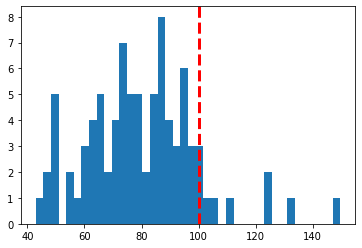

In [32]:
a=plt.hist([item[1] for item in sent_score_list],bins=40)
plt.axvline(100, color='r', linestyle='dashed', linewidth=3)

In [33]:
filter_sents=[]

for sent, val in sent_score_list:
    if val <=100:
        filter_sents.append([sent,val])

In [34]:
filter_sents[:10]

[['bed is located in basement that is part of house that is located near in tree trunk that is made of wood that is used for build furniture',
  46.71077],
 ['table is made of metal that is located near in handle that is part of door that is located in school that is used for learning',
  88.500175],
 ['ottoman is used for sitting that is located near in table that is made of stone that is located in gallbladder that is part of human body',
  85.66499],
 ['piano is located in drawing room that is used for sitting that is located near in porch that is part of house that is made of rooms',
  85.448074],
 ['bed is located in room that is located near in map that is used for information that is part of newspaper that is made of ink and paper',
  78.02122],
 ['table is made of wood that is located near in leg that is part of chair that is located in floor that is used for sitting on',
  50.34615],
 ['table is made of wood that is located near in cow that is located in ohio that is part of u

# New Task
The edges can have the thing as a subject or object
This requires double templates
X is used for Y
Y uses X

In [37]:
relation2label={"/r/UsedFor":"is used for","/r/CreatedBy":"is created by","/r/CapableOf":"is capable of",
                "/r/Causes":"casuses","/r/PartOf":"is part of","/r/HasContext":'has context,',"/r/MadeOf":"is made of",
                "/r/HasPrerequisite":"has prerequisite,","/r/CausesDesire": "causes desire,","/r/NotDesires":"does not desire",
                "/r/AtLocation":"is located in","/r/LocatedNear":"is located near in",
                "/r/AtLocation/r":"has","/r/UsedFor/r":"uses","/r/PartOf/r": "has a part,","/r/MadeOf/r":"is used to make","/r/LocatedNear/r":"is located near in",}

In [60]:
G = nx.DiGraph()
for edge in edges:
    sub,rel,obj=edge
    sub=sub.replace(" ","_")
    obj=obj.replace(" ","_")
    G.add_edge(sub,obj,label=rel)

In [62]:
G["bed"]["sit_on"]

{'label': '/r/UsedFor'}

In [224]:
def relation_walk_twoheads(threshold=10,relation_list=["/r/AtLocation","/r/LocatedNear","/r/UsedFor","/r/PartOf","/r/MadeOf"]):
    # random assign head num and tail num
    num_relation=len(relation_list)

    for i in range(threshold):
        sub=""
        obj=""
        relation_limit=set(relation_list)
        root_name = random.sample(label_limit, 1)[0].replace(" ","_")
        
        sub_connect=[sub,[]]
        obj_connect=[obj,[]]
        
        if G.has_node(root_name):
            pass
        else:
            continue
        relation_have=set()
        for connected_node in G[root_name]:
            relation_name=G[root_name][connected_node]["label"]
            
            if relation_name in relation_limit:
                relation_have.add(relation_name)
                
        if len(relation_have)>0:
            for connected_node in G[root_name]:
                relation_name=G[root_name][connected_node]["label"]
                
                obj_relation_have=set()
                if relation_name in relation_limit:
                    temp = list(G[connected_node])
                    random.shuffle(temp)
                    for connected_node2 in temp:
                        relation_name=G[connected_node][connected_node2]["label"]
                        
                        if relation_name in relation_limit:
                            obj_relation_have.add(relation_name)
                            
                    # check whether this subject and object satisfy the requirement
                    new_relation_have=relation_have.union(obj_relation_have)
                    
                    if len(new_relation_have)==len(relation_list):
                        sub=root_name
                        obj=connected_node
                        break
                    else:
                        continue
        else:
            # no relation_list
            continue
            
        if sub and obj:
            # both are assigned
            # try to find a road
            connect_relation = G[sub][obj]["label"]
            #print(sub, obj)
            #print(relation_limit,relation_have,obj_relation_have)
            relation_limit.remove(connect_relation)
            relation_have.remove(connect_relation)
            if connect_relation in obj_relation_have:
                obj_relation_have.remove(connect_relation)
            
            sub_num=len(relation_have)
            obj_num=len(obj_relation_have)
            
            sub_connect=[sub,[]]
            obj_connect=[obj,[]]
            if sub_num > obj_num:
                relation_have=relation_have.intersection(obj_relation_have)
                temp = list(G[obj])
                random.shuffle(temp)
                for node in temp:
                    relation_name=G[obj][node]["label"]
                    if relation_name in obj_relation_have:
                        obj_relation_have.remove(relation_name)
                        obj_connect[1].append(node)
                        
                temp = list(G[sub])
                random.shuffle(temp)
                for node in temp:
                    relation_name=G[sub][node]["label"]
                    if relation_name in relation_have:
                        relation_have.remove(relation_name)
                        sub_connect[1].append(node)
            else:
                obj_relation_have=obj_relation_have-relation_have
                temp = list(G[sub])
                random.shuffle(temp)
                #print(obj_relation_have)
                #print(relation_have)
                for node in temp:
                    relation_name=G[sub][node]["label"]
                    if relation_name in relation_have:
                        relation_have.remove(relation_name)
                        sub_connect[1].append(node)
                
                temp = list(G[obj])
                random.shuffle(temp)
                for node in temp:
                    relation_name=G[obj][node]["label"]
                    if relation_name in obj_relation_have:
                        obj_relation_have.remove(relation_name)
                        obj_connect[1].append(node)
            break
        else:
            continue
            
    return sub_connect, obj_connect

def build_sentence(sub_connect,obj_connect, relation_label={}):
    sub_sent=""
    obj_sent=""
    
    for i in range(len(sub_connect[1])):
        item = sub_connect[1][i]
        sub_connect[1][i]= relation_label[G[sub_connect[0]][item]["label"]]+" "+item
    sub_sent=sub_connect[0]+" "+" and ".join(sub_connect[1])
    
    for i in range(len(obj_connect[1])):
        item = obj_connect[1][i]
        obj_connect[1][i]= relation_label[G[obj_connect[0]][item]["label"]]+" "+item
    obj_sent=obj_connect[0]+" "+" and ".join(obj_connect[1])
    
    forward_sent= sub_sent+" "+relation2label[G[sub_connect[0]][obj_connect[0]]["label"]]+" "+obj_sent
    reverse_sent= obj_sent+" "+relation2label[G[sub_connect[0]][obj_connect[0]]["label"]+"/r"]+" "+sub_sent
    return forward_sent,reverse_sent

In [225]:
sub_connect,obj_connect=relation_walk_twoheads()
sub_connect,obj_connect

(['computer', ['arm', 'entertainment', 'hardware']], ['house', ['zodiac']])

In [226]:
build_sentence(sub_connect,obj_connect,relation_label=relation2label)

('computer is located near in arm and is used for entertainment and is made of hardware is located in house is part of zodiac',
 'house is part of zodiac has computer is located near in arm and is used for entertainment and is made of hardware')

In [227]:
# generate 10 sentence
forward_sents=[]
reverse_sents=[]
for i in tqdm(range(100)):
    sub_connect,obj_connect=relation_walk_twoheads()
    if not sub_connect[1] or not obj_connect[1]:
        continue
    forward_sent, reverse_sent=build_sentence(sub_connect,obj_connect,relation_label=relation2label)
    tokens_tensor = tokenizer.encode(forward_sent, add_special_tokens=False, return_tensors="pt")
    result_score1=score(tokens_tensor)
    
    tokens_tensor = tokenizer.encode(reverse_sent, add_special_tokens=False, return_tensors="pt")
    result_score2=score(tokens_tensor)
    forward_sents.append([forward_sent,result_score1])
    reverse_sents.append([reverse_sent,result_score2])

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]


In [229]:
forward_sents[:10]

[['rug is used for decoration is located near in window is located in building and is part of auto and is made of glass',
  129.48123],
 ['dresser is used for storing_clothing is located near in window is located in room and is made of glass and is part of auto',
  153.51976],
 ['toilet is located in restaurant and is made of porcelain is located near in house is used for home and is part of zodiac',
  88.93277],
 ['shower is part of house and is used for washing is located near in glass is located in dishwasher and is made of molten_sand',
  141.21385],
 ['dishwasher is used for washing_dishes is located near in window is located in building and is made of glass and is part of auto',
  109.83591],
 ['shower is used for bathing and is part of house is located near in glass is located in street and is made of sand',
  120.71493],
 ['fireplace is located in home and is used for decoration is located near in house is made of building_material and is part of zodiac',
  138.575],
 ['dishwas

In [228]:
reverse_sents[:10]

[['window is located in building and is part of auto and is made of glass is located near in rug is used for decoration',
  132.36784],
 ['window is located in room and is made of glass and is part of auto is located near in dresser is used for storing_clothing',
  118.3561],
 ['house is used for home and is part of zodiac is located near in toilet is located in restaurant and is made of porcelain',
  96.14476],
 ['glass is located in dishwasher and is made of molten_sand is located near in shower is part of house and is used for washing',
  90.51249],
 ['window is located in building and is made of glass and is part of auto is located near in dishwasher is used for washing_dishes',
  103.59777],
 ['glass is located in street and is made of sand is located near in shower is used for bathing and is part of house',
  111.273735],
 ['house is made of building_material and is part of zodiac is located near in fireplace is located in home and is used for decoration',
  158.384],
 ['window i

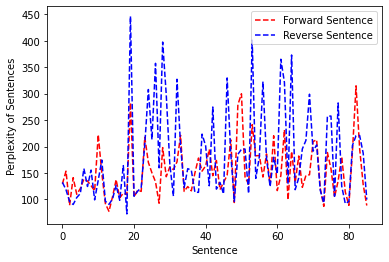

In [233]:
# draw a score graph
y1=[_[1] for _ in forward_sents]
y2=[_[1] for _ in reverse_sents]
x= range(len(forward_sents))

plt.xlabel('Sentence')
plt.ylabel('Perplexity of Sentences')
plt.plot(x,y1,'r--',label='Forward Sentence')
plt.plot(x,y2,'b--',label='Reverse Sentence')

plt.legend()

Text(0.5, 1.0, 'Perplexity Distribution Forward Sentence')

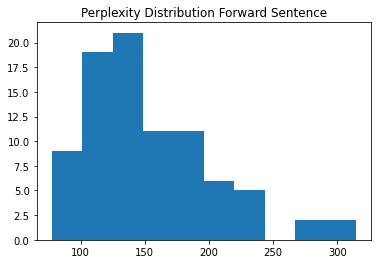

In [238]:
plt.hist(y1)
plt.title('Perplexity Distribution Forward Sentence')

Text(0.5, 1.0, 'Perplexity Distribution Reverse Sentence')

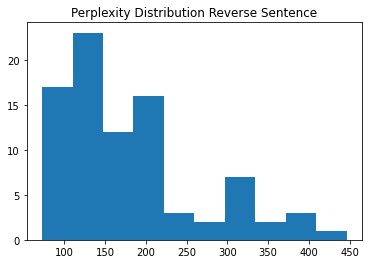

In [239]:
plt.hist(y2)
plt.title("Perplexity Distribution Reverse Sentence")